Tutorial 4: Integrating Multimodal Data with Ternary Plots
==========================================================

In Tutorial 2, we showed how to use the Laplacian score to determine whether a cell feature varies throughout the morphology space. Here, we discuss another technique to relate morphological distances to other cell features; in particular, we relate morphological distances to electrophysiological and molecular features of the cells. This technique allows us to identify variation in cells which is reflected _well_ through at least one of the indicators, but is reflected _poorly_ in the other indicators. It thus reveals "blind spots" in one of the measurement techniques, demonstrating the failure of one of the modes to capture distinctions which are well-reflected in the other modes.

Suppose that we have a set of cells $c_1,\dots, c_n$, and we associate to each cell an electrophysiological feature vector $e_1,\dots, e_n\in\mathbb{R}^k$, and a molecular feature vector $m_1,\dots, m_n\in \mathbb{R}^s$. Both the sets $\{e_1,\dots, e_n\}$ and $\{m_1,\dots, m_n\}$ can be regarded as spaces, and we can interpret the distance $\lVert e_i - e_j\rVert$ as the difference between cells $c_i,c_j$ which is visible from the point of view of electrophysiology; likewise for the molecular feature vectors. Together with the Gromov-Wasserstein space of morphological distances, this gives three different manifestations of the cell space, where the notion of distance of each space reflects one aspect of the cell.

Speaking broadly, we expect cells that are very different morphologically and very different electrophysiologically to be very different in their gene expression, as well. If there are many cell pairs in the data where large morphological and large electrophysiological distances aren't accompanied by large transcriptomic differences, it raises the question of why there is substantial variation in one variable not reflected in the others. For example, we might ask whether the transcriptomic methods are sufficiently comprehensive. This leads us to plot morphological, electrophysiological, and transcriptomic distances together.

This tutorial follows the dataset from the paper [Phenotypic variation of transcriptomic cell types in mouse motor cortexl](https://www.nature.com/articles/s41586-020-2907-3) by Scala et. al.
This [folder](https://www.dropbox.com/scl/fo/qqvbjfhitcaetxf4u6i87/h?rlkey=rn5xpegeden8sdmirjl1fav2j&dl=0) contains the SWC files and metadata we will use for the analysis; we refer to it below as `bd` for "base directory".

In [5]:
import os
import scipy
from scipy.spatial.distance import squareform, pdist
from os.path import join
import pandas as pd
from cajal.utilities import dist_mat_of_dict, read_gw_dists
from cajal.ternary import ternary_distance

import numpy as np
from cajal import run_gw, sample_swc, swc

bd = '/home/jovyan/ternary_example'

As in the other tutorials, we compute the intracell distance matrices and then the Gromov-Wasserstein distance matrix.

In [2]:
sample_swc.compute_icdm_all_euclidean(
    infolder=join(bd,'swcs'),
    out_csv=join(bd,'euclidean_100_icdm.csv'),
    n_sample=100,
    num_processes=20,
    preprocess=swc.preprocessor_eu([1,3,4],soma_component_only=False)
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 674/675 [12:41<00:01,  1.13s/it]


[]

In [3]:
run_gw.compute_gw_distance_matrix(
    intracell_csv_loc=join(bd,'euclidean_100_icdm.csv'),
    gw_dist_csv_loc=join(bd,'euclidean_100_gw.csv'),
    num_processes=20,
    verbose=True
)

  0%|          | 0/227475 [00:00<?, ?it/s]

(array([[  0.        ,  55.29024423,  20.89775085, ...,  89.46061727,
         114.35023329, 133.74968428],
        [ 55.29024423,   0.        ,  45.37596469, ...,  47.93968671,
          72.98299102,  91.40795753],
        [ 20.89775085,  45.37596469,   0.        , ...,  79.52789277,
         102.82544587, 122.88783354],
        ...,
        [ 89.46061727,  47.93968671,  79.52789277, ...,   0.        ,
          31.53549221,  50.41113986],
        [114.35023329,  72.98299102, 102.82544587, ...,  31.53549221,
           0.        ,  26.88432408],
        [133.74968428,  91.40795753, 122.88783354, ...,  50.41113986,
          26.88432408,   0.        ]]),
 None)

The file "m1_patchseq_meta_data.csv" contains the RNA families for the samples profiled in the study.

In [6]:
metadata = pd.read_csv(join(bd,"m1_patchseq_meta_data.csv"), delimiter="\t", index_col=1)
# Start with 1329 rows × 32 columns

cells, gw_dist_dict = read_gw_dists(join(bd,'euclidean_100_gw.csv'),header=True)

In [9]:
metadata = metadata.loc[cells]
metadata = metadata.loc[metadata['RNA family']!='low quality']
# We will filter out the RNA families with few elements.
metadata[(metadata['RNA family'].value_counts() > 30)[metadata['RNA family']].array]

# Labels for the classifier
print(metadata['RNA family'].unique())

['ET' 'IT' 'CT' 'NP' 'Pvalb' 'Vip' 'Sst' 'Lamp5' 'Sncg']


The files containing electrophysiological data and the exon counts have been cleaned to discard samples containing NaN values.

In [10]:
m1_patchseq_ephys_features=pd.read_csv(join(bd,'m1_patchseq_ephys_features.csv'),index_col='cell id')

In [26]:
ephys_data = pd.read_csv(join(bd,'ephys_data.csv'),index_col='cell id')
exon_data = pd.read_csv(join(bd,'exon_data.csv'), index_col='cell id')

We restrict to the samples for which we have all threee - morphological data, exon counts, and electrophysiology data.

In [27]:
common_cells = list(set(metadata.index).intersection(set(exon_data.index)).intersection(ephys_data.index))

In [28]:
# common_cells = list(set(metadata.index).intersection(set(exon_data.index)).intersection(ephys_data.index))
metadata = metadata.loc[common_cells]
exon_data = exon_data.loc[common_cells]
ephys_data = ephys_data.loc[common_cells]

We normalize the columns in the electrophysiology data so that they have mean 0 and standard deviation 1.
The "distance" in the electrophysiology space between two samples is defined to be 1 minus the Pearson correlation coefficient between the data for the samples. This is not a metric, but it is a common technique.

In [23]:
ephys_data = (ephys_data - ephys_data.mean())
ephys_data /= ephys_data.std()
ephys_dmat = (1-ephys_data.transpose().corr())

In [31]:
ephys_dmat = pd.DataFrame(squareform(pdist(ephys_data)), columns = common_cells, index = common_cells)

The following heuristic transformation is meant to narrow the long tails at the end of the distribution of exon counts.
As with the electrophysiology data, we use "correlation distance" as our notion of dissimilarity between samples.

In [29]:
exon_data = np.log(5000 * exon_data + 1)
exon_dmat = (1-((exon_data.transpose()).corr(method='pearson')))

!
-3.0735613168570297
6.337045113296438


(<Figure size 400x2800 with 7 Axes>,
  <matplotlib.tri._tricontour.TriContourSet at 0x7fcf3ff97190>])

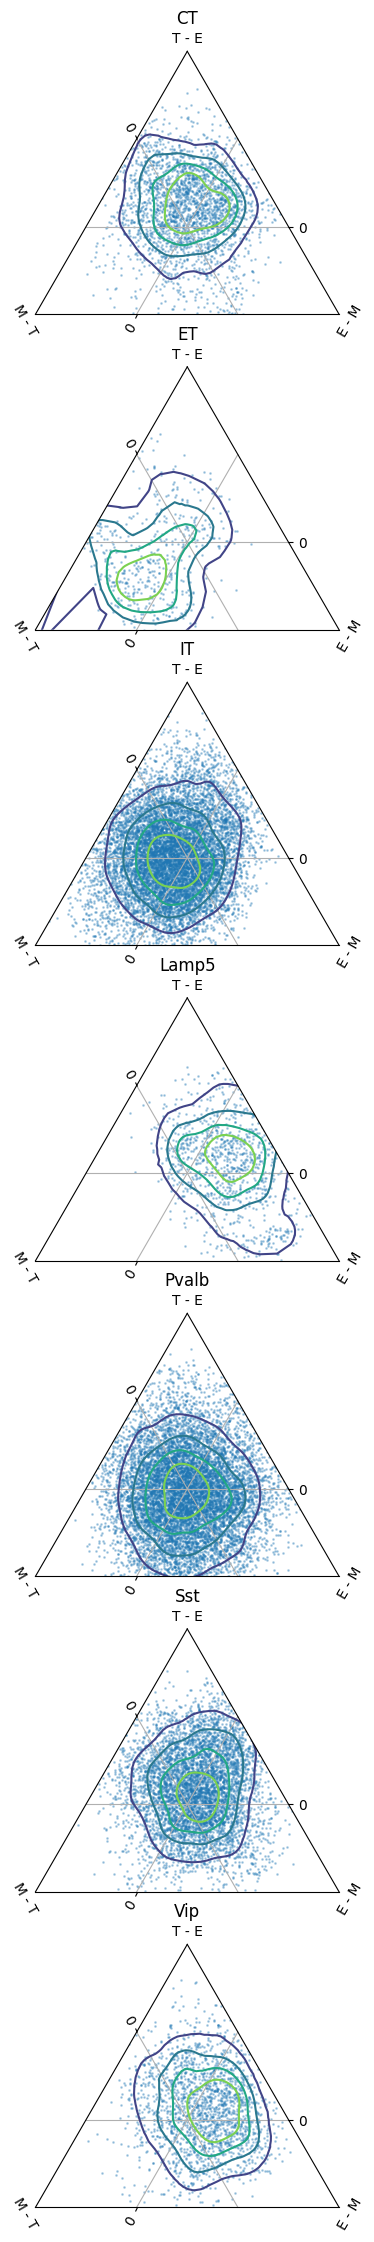

In [32]:
from cajal.ternary import ternary_distance_clusters
ternary_distance_clusters(
    exon_dmat.to_numpy(),
    'T', # Transcriptomic
    ephys_dmat.to_numpy(),
    'E', # Electrophysiological
    dist_mat_of_dict(gw_dist_dict,common_cells),
    'M', # Morphological
    density_estimation = 'gaussian_kde',
    bins = None,
    figsize = 4,
    clusters = metadata['RNA family'].to_numpy(),
    min_cluster_size = 30,
    mpl_params= { 's':1, 'alpha':.3 }
)